## Passive House Institute US Certification Case Analysis

As a former PHIKO (Passive House Institute KOrea) researcher, I became interested in PHIUS (Passive House Institute United States) certification projects data. PHIUS provides its certification projects database information on [their website](https://www.phius.org/phius-certification-for-buildings-products/certified-projects-database).

### Web scraping and Data organization
The data is not stored in csv format therefore, to make the analysis convenient, I will web-scrape the data and transform it into dataframe format using BeautifulSoup library.
<br>
<br>
<div>
<img src="page.png", width='1000'/>
</div>
<br>

In [13]:
import pandas as pd

# read the page using pandas 'read_html'
dfs = pd.read_html("https://www.phius.org/phius-certification-for-buildings-products/certified-projects-database", header=0)
table= dfs[0]

# strip the Project name column 
table['Project'] = table['Project'].str.strip()

# print the first five rows
table.head()

,No.,Project,Status,Lead CPHC,Builder,Location,Const. type,Bldg. function,Floor area,Project type,Unnamed: 10
0,1009,Center for Design Research (CDR),Pre-certified,Ryan Abendroth,Studio 804 - Kansas University,"Lawrence, KS",Timber,Government,2396.0,New Construction,NaN
1,1073,Hickory Hall,Pre-certified,Adam Cohen,Mod-U-Kraf,"Emory , VA",Timber,Commercial,29248.0,New Construction,NaN
2,1077,HABITAT FOR THE 21ST CENTURY,Pre-certified,Robert Moore,Habitat for Humanity,"Tacoma, WA",Timber,Single Family,1232.0,New Construction,NaN
3,1095,1202 Idaho Street,Pre-certified,Christopher Gonzales,Habitat for Humanity of Gallatin Valley,"Belgrade, MT",Timber,Single Family,1604.0,New Construction,NaN
4,1117,The Passive-Agressive Home,Pre-certified,Vic Weber,Oak Tree Homes,"Wilton, IA",Mixed timber-masonry,Single Family,3410.0,New Construction,NaN


For the location analysis later, let's split the location data into 'state' and 'city' 

In [14]:
# Splitting Location column and extracting state and city data
table['state'] = table['Location'].str.split(',').str[-1].str.strip()
table['city'] = table['Location'].str.split(',').str[0].str.strip()

By using pandas read_html function, we can easily create a dataframe for the page. However, for analysis purposes, 'Certification Date' data is crucial but it does not existed on the page. We can obtain this data by accessing the project name href. In order to access the project name href, I made a dictionary that contains the project name as a key and the web address as a value.

In [15]:
import bs4 as bs
from bs4 import BeautifulSoup
import urllib.request

sauce = urllib.request.urlopen("https://www.phius.org/phius-certification-for-buildings-products/certified-projects-database").read()
soup = BeautifulSoup(sauce, 'lxml')

# creating dict with project name as a key and link address as a value
dic={}
for a in soup.find_all('a', href=True):
    dic[a.text] = a['href']

# appending 'https://www.phius.org/'
for i in dic:
    dic[i] = 'https://www.phius.org/' + dic[i]

I found some project names containing a blank space, hence I added a process to strip that useless space.

In [16]:
# strip the key in dict
dict_striped = {}    
for i in dic:
    if i != i.strip():
        dict_striped[i.strip()] = dic[i]
    else:
        dict_striped[i] = dic[i]

Below shows the example page after entering the project name link.

<img src="detail_page.png">

As you can see above, on the right bottom corner, there is a 'Certification Date' data. I will extract that data by using 'find_next.text' function.

In [17]:
# Extracting "Certification Date" data
project_year = {}
for i in table['Project']:
    url = dict_striped[i]
    sauce = urllib.request.urlopen(url).read()
    soup = BeautifulSoup(sauce, 'lxml')
    td = soup.find("th", text="Certification Date").find_next("td").text
    project_year[i] = td

URLError: <urlopen error [WinError 10060] A connection attempt failed because the connected party did not properly respond after a period of time, or established connection failed because connected host has failed to respond>

The cerfitication date data is stored in the 'project_year' dictionary. Let's convert that dictionary into a list and append it on 'table' dataframe.

In [ ]:
# converting dictionary into a list
certification_date = []
for i in project_year:
    certification_date.append(project_year[i])

# appending 'Certification Date' data column to 'table' dataframe
table['date'] = certification_date_column

# extracting year data from 'date' column
table['date'] = table['date'].str.split(n=3)
table['year'] = table['date'].str[-1]

table.head()

Finally, we have a nice and clean dataset for the analysis.

### Data Visualization - Yearly Number of Project Cases

In [18]:
import pandas as pd
table = pd.read_csv('table.csv', encoding='unicode_escape')

Comparing the features (e.g. building function, proejct type, and construction type) of Passivouse projects in Korea and US seems interesting. I created a yearly number of project case charts per each project feature.

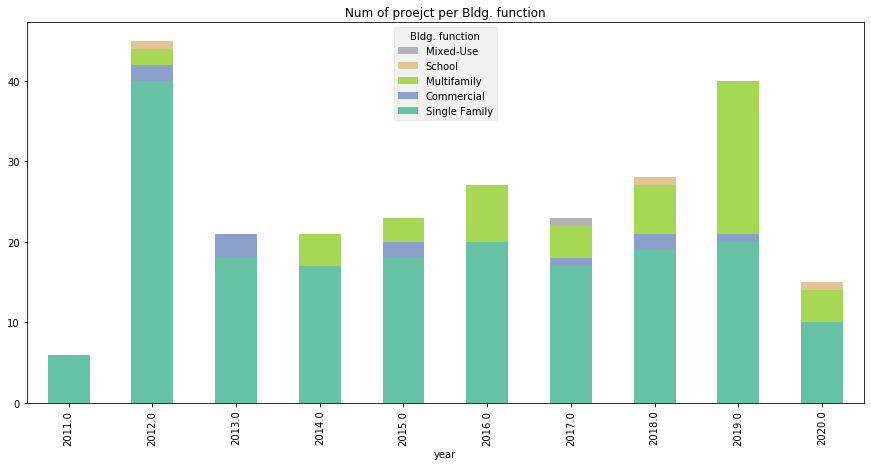

In [19]:
import matplotlib.pyplot as plt
%matplotlib inline

# Create a plot describing the number of projects per year and per bldg. function 
# set the plot figure size
fig, ax = plt.subplots(figsize=(15,7))

# Create a stacked plot using groupby function
table.groupby(['year','Bldg. function']).count()['No.'].unstack().plot(ax=ax, kind='bar', stacked=True, cmap='Set2')

# set the plot title
plt.title('Num of proejct per Bldg. function')

# set the plot style
plt.style.use('bmh')

# reverse the legend order
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], title='Bldg. function', loc='best')

#### Building Function - Number of Project

As you can see in the figure above, categorizing it with 'Building Function', most of them are 'Single Family' (62%) and the following are 'Multifamily' (28%), 'Commercial' (6%), 'Mixed-Use' (2%), 'School' (2%). As you can see in the graph above, during the period between 2018-2019, there is significant increase in 'Multifamily' projects even though there is not much of a difference in the 'Single Family' projects. The y-value means the number of "projects" not the number of "buildings". (For example, in the case of 'Washington Square Town Homes' project, although it consists of 24 units, we count it as one project.) 

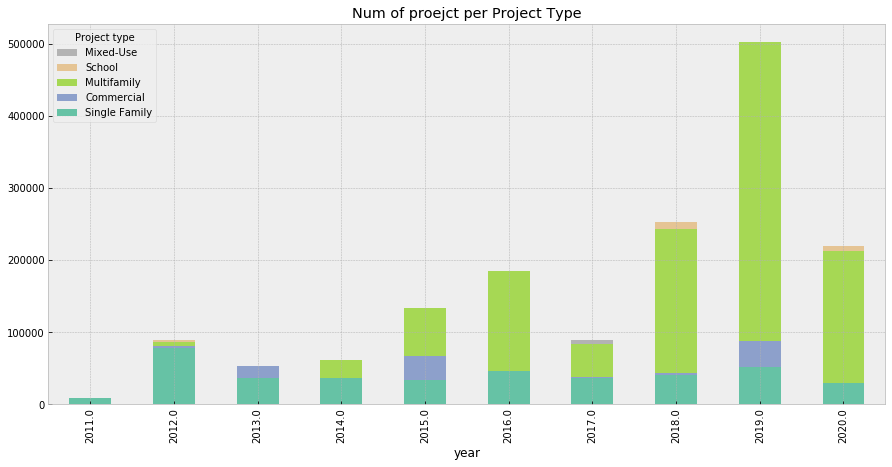

In [20]:
# Create a plot describing the sum of floor area per projects per year and bldg. function 
# set the plot figure size
fig, ax = plt.subplots(figsize=(15,7))

# Create a stacked plot using groupby function
table.groupby(['year','Bldg. function']).sum()['Floor area'].unstack().plot(ax=ax, kind='bar', stacked=True, cmap='Set2')

# set the plot title
plt.title('Num of proejct per Project Type')

# set the plot style
plt.style.use('bmh')

# reverse the legend order
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], title='Project type', loc='best')

#### Building Function - Sum of floor area

If we display the sum floor area grouping with building functions, we can clearly notice the increase in 'Multifamily' projects between 2018-2019. 'Multifamily' projects includes Duplex (2 unit), Quadruplex (4 unit), Townhouse (multi-unit), and Apartment Building (multi-unit). In the event of the 'Single Family' project, it is common that building owners develop the projects for living purposes and living in that building himself/ herself. (i.e. owner = resident). On the other hand, in the case of the 'Multifamily' project, the building owner develops the project for his/ her "profit" so the owner rents or sells them out (i.e. owner ≠ resident) afterwards.

America is capitalism to the bone. It must be rare for an American developer to build a Passivehouse for their tanents' health benefit. After crunching numbers, economically it must have made ends meet for the owner (the developer). I suppose the economical advantages which the developer can take are federal and state government's tax benefit, heating & cooling cost saving, and marketing means for leasing or sales. I will look into it later.

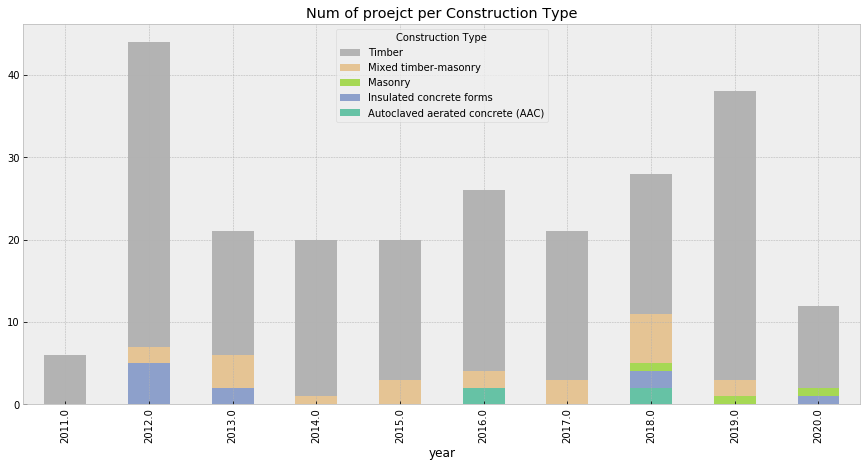

In [21]:
# Create a plot describing the number of projects per year and construction type 
# set the plot figure size
fig, ax = plt.subplots(figsize=(15,7))

# Create a stacked plot using groupby function
table.groupby(['year','Const. type']).count()['No.'].unstack().plot(ax=ax, kind='bar', stacked=True, cmap='Set2')

# set the plot title
plt.title('Num of proejct per Construction Type')

# set the plot style
plt.style.use('bmh')

# reverse the legend order
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], title='Construction Type', loc='best')

#### Construction Type

I found the remarkable point is that there are not many 'Concrete' structures in the light of the fact that concrete structure has a high thermal storage performance. In the data above, majority of them is 'Timber' structure (69%) and the following are 'Mixed timber-masonry' (10%), 'Masonry'(4%), 'Insulated Concrete Forms'(4%), 'Autoclaved aerated concrete (AAC)' (2%) among total 393 projects (n/a: 12%). 

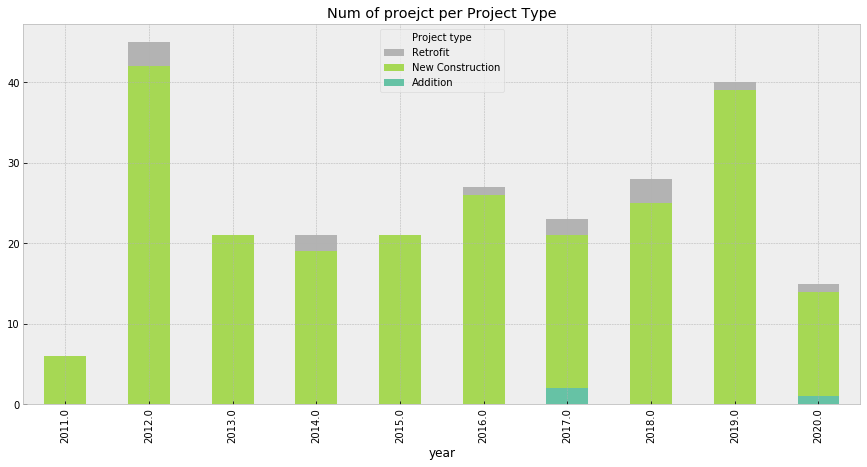

In [22]:
# Create a plot describing the number of projects per year and project type 
# set the plot figure size
fig, ax = plt.subplots(figsize=(15,7))

# Create a stacked plot using groupby function
table.groupby(['year','Project type']).count()['No.'].unstack().plot(ax=ax, kind='bar', stacked=True, cmap='Set2')

# set the plot title
plt.title('Num of proejct per Project Type')

# set the plot style
plt.style.use('bmh')

# reverse the legend order
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], title='Project type', loc='best')

#### Project Type

Categorizing them with project type, most of them are 'New Construction' (92%) and the following are 'Retrofit' (5%), and 'Addition' (1%). In the light of the fact that numerous retrofit researches and policies for better building performance have been conducted globally, the proportion of the 'Retrofit' (5%) project is relatively low. We can speculate the reason by referring the PHIUS certification guide book. 
<br>
<br>
<div>
<img src="retrofit_guidebook.png", width='500'/>
</div>
<br>
<br>

Basically, the code for the retrofit project is same as new construction except for the foundation perimeter, which is hard to be corrected. In case of German PHI, they have distinct retrofit certification code which is 'Enerphit' and this is one of the difference in German PHI and American PHIUS.

### Data Visulaization - Choropleth Map

I became curious 'Where in states the Passivehouse is popular?'. Let's visulaize it with Choropleth Map.

In [23]:
from plotly.offline import plot, iplot
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode

Before creating the map, we need to add a column that contains number of projects in each state.

In [24]:
# creating a column containing the number of projects in each state
table['state_count'] = table['No.'].groupby(table['state']).transform('count')
table.head()

,Unnamed: 0,No.,Project,Status,Lead CPHC,Builder,Location,Const. type,Bldg. function,Floor area,Project type,Unnamed: 10,date,year,month,state,city,state_count
0,0,1009,Center for Design Research (CDR),Pre-certified,Ryan Abendroth,Studio 804 - Kansas University,"Lawrence, KS",Timber,Government,2396.0,New Construction,NaN,[],NaN,NaN,KS,Lawrence,3.0
1,1,1073,Hickory Hall,Pre-certified,Adam Cohen,Mod-U-Kraf,"Emory , VA",Timber,Commercial,29248.0,New Construction,NaN,[],NaN,NaN,VA,Emory,20.0
2,2,1077,HABITAT FOR THE 21ST CENTURY,Pre-certified,Robert Moore,Habitat for Humanity,"Tacoma, WA",Timber,Single Family,1232.0,New Construction,NaN,[],NaN,NaN,WA,Tacoma,26.0
3,3,1095,1202 Idaho Street,Pre-certified,Christopher Gonzales,Habitat for Humanity of Gallatin Valley,"Belgrade, MT",Timber,Single Family,1604.0,New Construction,NaN,[],NaN,NaN,MT,Belgrade,1.0
4,4,1117,The Passive-Agressive Home,Pre-certified,Vic Weber,Oak Tree Homes,"Wilton, IA",Mixed timber-masonry,Single Family,3410.0,New Construction,NaN,[],NaN,NaN,IA,Wilton,5.0


In [25]:
# creating a Chropleth Map using plotly.graph_objs
data = dict(type='choropleth',
            locations = table['state'],
            locationmode = 'USA-states',
            colorscale = 'Reds',
            text = table['state'],
            z = table['state_count'],
            colorbar = {'title':"State Count"}
            )
layout = dict(title = 'PHIUS Project Map', geo = dict(scope='usa')
             )
choromap = go.Figure(data = [data], layout = layout)
iplot(choromap)

#### Geographical Distribution

Statewide, Passivehouse projects are concentrated in New York (16%) and Philadelphia (14%) and the followings are Washington (6%), Illinois (6%), and Oregon (6%). (PHIUS headquater is located in Illinois). 

Globalwide, there are cases out of USA which are in Canada (6%, 27 cases), Korea (1 case), Japan (1 case). The project in Korea is '2012 Yangpyeong Passive House' (Architect: Engineforce Architect, Construction: HAOS).

### Summary

To summarize, building function wise the majority of the project is 'Single Family' project but we noticed that there is a dramatic increase of 'Multifamily' proejcts during 2018-2019. The vast portion of the project is 'New Construction' and the 'Timber' is the most popular structure. It's noteworthy that that there are not many concrete structures considering the fact that it is the most beneficial structure for heating storage which should not be overlooked in terms of building performance. Moreover, geographically, projects are concentrated in New York (16%) and Philadelphia (14%).